#**GetAround Project Summary:**

GetAround, founded in 2009, operates as a platform similar to Airbnb but for cars, allowing users to rent cars from private owners for short periods (from hours to days). By 2019, the platform had over 5 million users and 20,000 cars worldwide.

The rental process involves check-in and check-out flows to assess car conditions, fuel levels, and kilometers driven. These flows can be completed in three ways:

- Mobile rental agreement (driver and owner meet, sign on the owner’s smartphone).
- Connect (driver opens the car with their smartphone without meeting the owner).
- Paper contracts (rarely used).

**Project Context:**

Late returns from drivers cause friction for subsequent renters, as it delays the car's availability. This often leads to customer complaints, cancellations, or dissatisfaction. To address this, GetAround wants to implement a minimum delay between rentals to prevent booking too closely.

**Goals: The company seeks to determine:**
- The appropriate minimum delay between rentals.
- Whether the feature should apply to all cars or just Connect cars.

They need insights on:
- How much owner revenue might be impacted by the delay.
- The potential number of rentals affected by the delay, based on threshold and scope.
- How often drivers are late and the impact on the next driver.
- The effectiveness of the feature in solving problems based on the chosen threshold and scope.

Key Analyses to Perform:

    Impact on Owner's Revenue:
        Calculate the share of revenue affected by the late check-ins by analyzing how many rentals are delayed. We can determine which rentals are overlapping or impacted by late check-ins and compute the revenue lost or delayed based on that.
    Rentals Affected by Threshold and Scope:
        We can test different threshold values (minimum delay between rentals) to see how many rentals would be impacted under different delay thresholds. Additionally, we can focus on analyzing the effect specifically for Connect cars versus all cars to understand the scope.
    Late Check-ins and Impact on the Next Driver:
        Analyze the frequency of late check-ins by comparing the delay_at_checkout_in_minutes to zero. We can also compute how often late check-ins prevent the next rental from starting on time and the associated impact on the following driver.
    Problematic Cases Solved by Different Thresholds:
        By varying the delay threshold, we can estimate how many late check-ins (problematic cases) are solved. For each threshold, we can count the number of delayed rentals and analyze how many of them would no longer cause issues with the new minimum delay.

Steps to Proceed:

    Revenue Impact: We can estimate the potential lost revenue based on how many delayed rentals overlap with the next rental period.
    Threshold Impact: We can simulate different delay thresholds and check how many rentals would be affected by the minimum delay.
    Late Check-in Analysis: Track how often late check-ins occur and the effect they have on subsequent rentals.
    Problematic Cases by Threshold: Calculate how the threshold could mitigate late check-ins.

The dataset contains information about car rentals with the following columns:

    rental_id: Unique identifier for the rental.
    car_id: Identifier for the car rented.
    checkin_type: The method used for check-in (e.g., mobile or connect).
    state: The status of the rental (e.g., canceled, ended).
    delay_at_checkout_in_minutes: The delay in minutes at checkout. Some values are missing (NaN).
    previous_ended_rental_id: ID of the previous rental if the current rental is part of a sequence of rentals.
    time_delta_with_previous_rental_in_minutes: The time difference between this rental and the previous rental in minutes.

In [44]:
import pandas as pd

import matplotlib.pyplot as plt

In [8]:
data = pd.read_excel('/content/get_around_delay_analysis.xlsx')
data.head()

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
0,505000,363965,mobile,canceled,NaN,NaN,NaN
1,507750,269550,mobile,ended,-81.0,NaN,NaN
2,508131,359049,connect,ended,70.0,NaN,NaN
3,508865,299063,connect,canceled,NaN,NaN,NaN
4,511440,313932,mobile,ended,NaN,NaN,NaN


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21310 entries, 0 to 21309
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rental_id                                   21310 non-null  int64  
 1   car_id                                      21310 non-null  int64  
 2   checkin_type                                21310 non-null  object 
 3   state                                       21310 non-null  object 
 4   delay_at_checkout_in_minutes                16346 non-null  float64
 5   previous_ended_rental_id                    1841 non-null   float64
 6   time_delta_with_previous_rental_in_minutes  1841 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.1+ MB


##Dataset summary and basic statistics

In [37]:
# Let's first check for some basic statistics and distributions of the delay column
delay_stats = data['delay_at_checkout_in_minutes'].describe()
print('Distributions of the delay_at_checkout_in_minutes column:')
print(delay_stats)

# Checking for any missing values
missing_values = data.isnull().sum() / len(data) * 100
print('\nMissing values:')
print(missing_values)

# Distribution of rental states
rental_state_distribution = data['state'].value_counts()
print('\nDistribution of rental states:')
print(rental_state_distribution)

# Correlation between delay and time delta with previous rental
correlation_delay_time_delta = data[['delay_at_checkout_in_minutes', 'time_delta_with_previous_rental_in_minutes']].corr()
print('\nCorrelation between delay and time with previous rental:')
print(correlation_delay_time_delta)

Distributions of the delay_at_checkout_in_minutes column:
count    16346.000000
mean        59.701517
std       1002.561635
min     -22433.000000
25%        -36.000000
50%          9.000000
75%         67.000000
max      71084.000000
Name: delay_at_checkout_in_minutes, dtype: float64

Missing values:
rental_id                                      0.000000
car_id                                         0.000000
checkin_type                                   0.000000
state                                          0.000000
delay_at_checkout_in_minutes                  23.294228
previous_ended_rental_id                      91.360863
time_delta_with_previous_rental_in_minutes    91.360863
dtype: float64

Distribution of rental states:
state
ended       18045
canceled     3265
Name: count, dtype: int64

Correlation between delay and time with previous rental:
                                            delay_at_checkout_in_minutes  \
delay_at_checkout_in_minutes                             

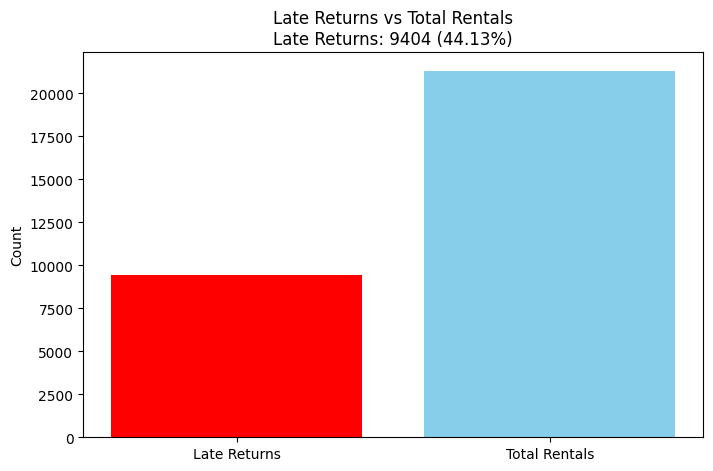

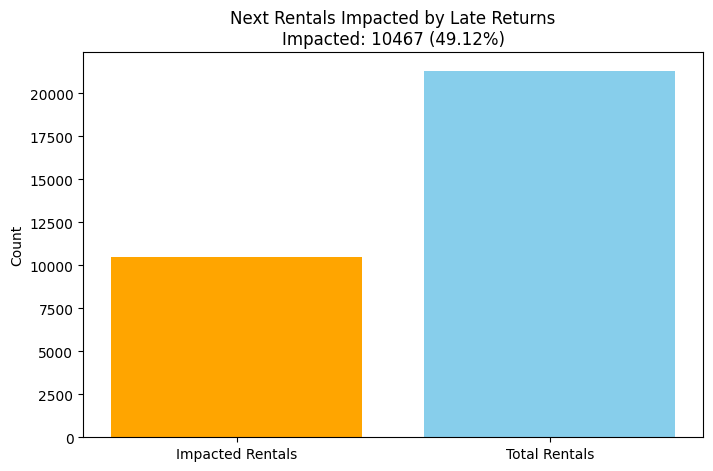

(9404, 44.12951665884562, 10467, 49.11778507742844)

In [57]:
# First, filter rentals with delays
late_returns = data[data['delay_at_checkout_in_minutes'] > 0]

# Calculate number of late returns and percentage
late_return_count = late_returns.shape[0]
total_rentals = data.shape[0]
late_return_percentage = (late_return_count / total_rentals) * 100

# Sort the data by car_id and rental_id to track the sequence of rentals for each car
rentals_data_sorted = data.sort_values(by=['car_id', 'rental_id'])

# Calculate the time difference between consecutive rentals
rentals_data_sorted['next_rental_delay'] = rentals_data_sorted.groupby('car_id')['delay_at_checkout_in_minutes'].shift(-1)

# Filter rows where the next rental is impacted by a late return
delayed_next_rental = rentals_data_sorted[rentals_data_sorted['next_rental_delay'].notnull()]

# Calculate the number of impacted next rentals and percentage
impacted_next_rentals = delayed_next_rental.shape[0]
impacted_next_rentals_percentage = (impacted_next_rentals / total_rentals) * 100

# Visualization 1: Bar chart of late returns
plt.figure(figsize=(8,5))
plt.bar(['Late Returns', 'Total Rentals'], [late_return_count, total_rentals], color=['red', 'skyblue'])
plt.title(f'Late Returns vs Total Rentals\nLate Returns: {late_return_count} ({late_return_percentage:.2f}%)')
plt.ylabel('Count')
plt.show()

# Visualization 2: Impacted next rentals due to late returns
plt.figure(figsize=(8,5))
plt.bar(['Impacted Rentals', 'Total Rentals'], [impacted_next_rentals, total_rentals], color=['orange', 'skyblue'])
plt.title(f'Next Rentals Impacted by Late Returns\nImpacted: {impacted_next_rentals} ({impacted_next_rentals_percentage:.2f}%)')
plt.ylabel('Count')
plt.show()

# Display the calculated results
late_return_count, late_return_percentage, impacted_next_rentals, impacted_next_rentals_percentage

**Insights from the Visualizations:**

**1. Late Returns vs Total Rentals:**
- 9,404 rentals (44.13% of the total) are late for the next check-in. This indicates a significant portion of rentals is delayed, which could affect future bookings.

**2. Next Rentals Impacted by Late Returns:**
- 10,467 rentals (49.12% of the total) are impacted by these late returns. This highlights the effect that late check-ins have on subsequent rentals, potentially causing friction for future drivers.

**Conclusion:**
- The late returns are a considerable issue, with nearly half of the rentals being impacted by delays.
- This information can help evaluate how much the minimum delay threshold feature could reduce friction and improve customer satisfaction.

#Analysis on Impact of Different Tresholds

1. Simulate Different Thresholds: We will simulate different thresholds (e.g., 10, 20, 30, 40, 60 minutes) and calculate how many rentals would be affected by each threshold.
2. Problematic Cases Solved: For each threshold, we will estimate how many late check-ins would no longer cause issues (i.e., how many would be within the acceptable delay limit for the next rental).

##Let proceed with the calculations for various threshold values.

In [47]:
# Defining the thresholds to simulate (in minutes)
thresholds = [10, 20, 30, 40, 50, 60]

# Initialize a dictionary to store the results for each threshold
threshold_impact = {}

# Iterate through each threshold and calculate the impact
for threshold in thresholds:
    # Mark rentals that would still cause issues if the minimum delay threshold is applied
    affected_rentals = rentals_data_sorted[rentals_data_sorted['delay_at_checkout_in_minutes'] > threshold]

    # Calculate the number of affected rentals and the percentage
    affected_count = affected_rentals.shape[0]
    affected_percentage = (affected_count / total_rentals) * 100

    # Calculate how many problematic cases are solved by the threshold
    solved_cases = late_return_count - affected_count
    solved_cases_percentage = (solved_cases / late_return_count) * 100

    # Store results in the dictionary
    threshold_impact[threshold] = {
        'affected_rentals_count': affected_count,
        'affected_rentals_percentage': affected_percentage,
        'solved_cases_count': solved_cases,
        'solved_cases_percentage': solved_cases_percentage
    }

# Convert the results to a DataFrame for better presentation
threshold_impact_df = pd.DataFrame(threshold_impact).T
threshold_impact_df.columns = ['Affected Rentals Count', 'Affected Rentals Percentage', 'Solved Cases Count', 'Solved Cases Percentage']

#import ace_tools as tools; tools.display_dataframe_to_user(name="Threshold Impact Analysis", dataframe=threshold_impact_df)


In [48]:
threshold_impact_df

,Affected Rentals Count,Affected Rentals Percentage,Solved Cases Count,Solved Cases Percentage
10,7980.0,37.447208,1424.0,15.142493
20,6914.0,32.444862,2490.0,26.478094
30,6078.0,28.521821,3326.0,35.367929
40,5393.0,25.307367,4011.0,42.652063
50,4850.0,22.759268,4554.0,48.426202
60,4386.0,20.581886,5018.0,53.360272


Here, are the results of the threshold analysis, showing the impact of different delay thresholds on the number of affected rentals and the problematic cases that can be solved.

Here’s a summary:

  - As the threshold increases, fewer rentals are affected by late returns.
  - The number of problematic cases solved also increases with the threshold, especially when it reaches 60 minutes, where about 53.36% of the problematic cases are resolved.

##Visualization of Affected Rentals and Solved Cases based on different thresholds

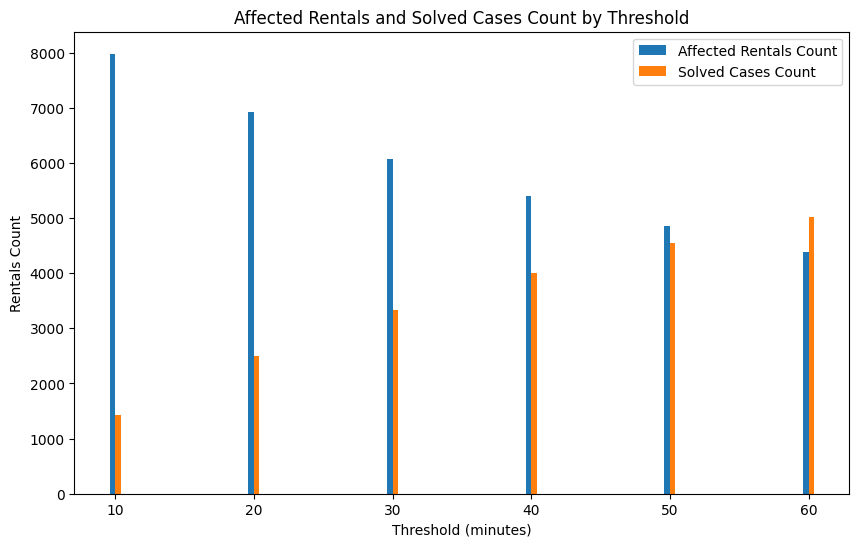

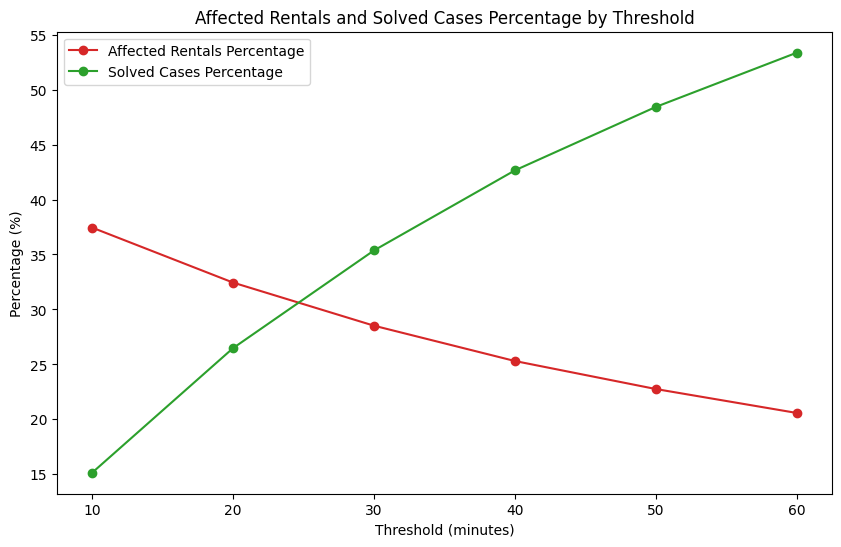

In [49]:
# Plot for Affected Rentals and Solved Cases Count (Bar Chart)
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(threshold_impact_df.index - 0.2,
        threshold_impact_df['Affected Rentals Count'],
        width=0.4, label='Affected Rentals Count',
        color='tab:blue')
ax1.bar(threshold_impact_df.index + 0.2,
        threshold_impact_df['Solved Cases Count'],
        width=0.4, label='Solved Cases Count',
        color='tab:orange')

ax1.set_xlabel('Threshold (minutes)')
ax1.set_ylabel('Rentals Count')
ax1.set_title('Affected Rentals and Solved Cases Count by Threshold')
ax1.legend()

plt.xticks(ticks=threshold_impact_df.index, labels=threshold_impact_df.index)
plt.show()

# Plot for Affected Rentals and Solved Cases Percentage (Line Chart)
fig, ax2 = plt.subplots(figsize=(10, 6))

ax2.plot(threshold_impact_df.index,
         threshold_impact_df['Affected Rentals Percentage'],
         label='Affected Rentals Percentage',
         marker='o',
         color='tab:red')
ax2.plot(threshold_impact_df.index,
         threshold_impact_df['Solved Cases Percentage'],
         label='Solved Cases Percentage',
         marker='o',
         color='tab:green')

ax2.set_xlabel('Threshold (minutes)')
ax2.set_ylabel('Percentage (%)')
ax2.set_title('Affected Rentals and Solved Cases Percentage by Threshold')
ax2.legend()

plt.xticks(ticks=threshold_impact_df.index, labels=threshold_impact_df.index)
plt.show()


**Explanation of Affected Rentals and Solved Cases:**

**Affected Rentals:**
These are the rentals where the checkout is delayed by more than the specified threshold (e.g., 10, 20, 30, etc. minutes). In other words, a rental is considered "affected" when the driver returns the car late, potentially causing issues for the next scheduled rental.

For example:
- If the threshold is set to 30 minutes, any rental where the delay at checkout exceeds 30 minutes is counted as an affected rental. This means the car was returned late, which could prevent the next renter from using it on time.

**Solved Cases:**

These refer to the rentals where the delay at checkout would have been problematic for the next rental but is now mitigated by applying the delay threshold. In other words, when the threshold is applied, these rentals no longer cause issues for the subsequent rental.

For example:
- If the threshold is 30 minutes, any late rental that was previously affecting the next rental (because the checkout was delayed beyond 30 minutes) is now considered "solved." Essentially, if the delay is within the threshold, it would not cause an issue for the next rental.

**Impact of Threshold on Rentals:**
- As the threshold increases, fewer rentals are considered affected because more delays are within the acceptable limit. This means that solved cases also increase as the threshold grows, showing that more late check-ins are no longer problematic for the next rentals.

**In Summary:**

- **Affected Rentals:** Rentals that are delayed beyond the chosen threshold.
- **Solved Cases:** Rentals that would have caused issues but are no longer problematic because their delay is within the threshold.

As the threshold increases, you can see a reduction in the number of affected rentals and an increase in the number of solved cases, meaning that fewer future rentals are impacted by delays.